# Detailed Evaluation

This notebook shows how to produce some tables and plots for analysing results. This is meant as a starting point, because eah game will require a custom evaluation depending on its metrics and experiments.

This notebook uses the output files of evaluation/bencheval.py. Run that first.

In [9]:
import sys
sys.path.append('..')

from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.patches import Polygon

import evaluation.evalutils as utils
from evaluation.makingtables import build_dispersion_table
import clemgame.metrics as clemmetrics

Choose path for the .csv with the raw scores. This is created after running ```bencheval.py```.

In [10]:
RAW_PATH = Path('../results/raw.csv')
raw_df = pd.read_csv(RAW_PATH, index_col=0)

Let's inspect the contents of ```data```:

In [11]:
raw_df

,game,model,experiment,episode,metric,value
0,matchit_ascii_5q,gpt-4o-2024-05-13-t0.0--gpt-4o-2024-05-13-t0.0,2_similar_grid_2,episode_5,Violated Request Count,0.0
1,matchit_ascii_5q,gpt-4o-2024-05-13-t0.0--gpt-4o-2024-05-13-t0.0,2_similar_grid_2,episode_5,Parsed Request Count,24.0
2,matchit_ascii_5q,gpt-4o-2024-05-13-t0.0--gpt-4o-2024-05-13-t0.0,2_similar_grid_2,episode_5,Request Count,24.0
3,matchit_ascii_5q,gpt-4o-2024-05-13-t0.0--gpt-4o-2024-05-13-t0.0,2_similar_grid_2,episode_5,Aborted,0.0
4,matchit_ascii_5q,gpt-4o-2024-05-13-t0.0--gpt-4o-2024-05-13-t0.0,2_similar_grid_2,episode_5,Success,1.0
...,...,...,...,...,...,...
116558,matchit,gpt-4-1106-vision-preview-t0.0--gpt-4-1106-vis...,0_same_image,episode_6,Played,1.0
116559,matchit,gpt-4-1106-vision-preview-t0.0--gpt-4-1106-vis...,0_same_image,episode_8,Played,1.0
116560,matchit,gpt-4-1106-vision-preview-t0.0--gpt-4-1106-vis...,0_same_image,episode_9,Played,1.0
116561,matchit,gpt-4-1106-vision-preview-t0.0--gpt-4-1106-vis...,0_same_image,episode_7,Played,1.0


If we want to evaluate a single game and the results directory contained more games, we can filter the game column:

In [94]:
game_df = raw_df.loc[raw_df["game"].isin(["mm_mapworld", "mm_mapworld_graphs", "mm_mapworld_qa", "mm_mapworld_specificroom"])]

name_map = {
    "mm_mapworld": "EE",
    "mm_mapworld_graphs": "EE-gr",
    "mm_mapworld_qa": "EE-qa",
    "mm_mapworld_specificroom": "G2X"
}
experiment_map = {
    "0_none": "0: None",
    "1_limited": "1: Limited",
    "2_strong": "2: Strong",
    "0_small": "0: Small",
    "1_medium": "1: Medium",
    "2_large": "2: Large",
    "3_medium_cycle": "3: Medium + Cycle",
    "4_large_cycle": "4: Large + Cycle",
    "0_on": "0: On",
    "1_close": "1: Close",
    "2_far": "2: Far"
}

# replace the names in game_df using the name_map
game_df["game"] = game_df["game"].map(name_map)
game_df["experiment"] = game_df["experiment"].map(experiment_map)

game_df



/tmp/ipykernel_1028/1403739367.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_df["game"] = game_df["game"].map(name_map)
/tmp/ipykernel_1028/1403739367.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_df["experiment"] = game_df["experiment"].map(experiment_map)


,game,model,experiment,episode,metric,value
280,EE-qa,gpt-4o-2024-05-13-t0.0--gpt-4o-2024-05-13-t0.0,0: None,episode_5,Aborted,1.0
281,EE-qa,gpt-4o-2024-05-13-t0.0--gpt-4o-2024-05-13-t0.0,0: None,episode_5,Success,NaN
282,EE-qa,gpt-4o-2024-05-13-t0.0--gpt-4o-2024-05-13-t0.0,0: None,episode_5,Lose,NaN
283,EE-qa,gpt-4o-2024-05-13-t0.0--gpt-4o-2024-05-13-t0.0,0: None,episode_5,moves,NaN
284,EE-qa,gpt-4o-2024-05-13-t0.0--gpt-4o-2024-05-13-t0.0,0: None,episode_5,valid_moves,NaN
...,...,...,...,...,...,...
115909,EE-gr,gpt-4-1106-vision-preview-t0.0--gpt-4-1106-vis...,1: Medium,episode_6,Played,1.0
115910,EE-gr,gpt-4-1106-vision-preview-t0.0--gpt-4-1106-vis...,1: Medium,episode_8,Played,1.0
115911,EE-gr,gpt-4-1106-vision-preview-t0.0--gpt-4-1106-vis...,1: Medium,episode_9,Played,1.0
115912,EE-gr,gpt-4-1106-vision-preview-t0.0--gpt-4-1106-vis...,1: Medium,episode_7,Played,1.0


## Overview tables

Get dispersion metrics over all episodes. Note that we use groupby, which will ignore NaN values, according to the documentation!

In [70]:
stats_df = build_dispersion_table(['game', 'model', 'metric'], game_df) # could also use raw_df for results for all games

Break results down by experiment:

In [71]:
detailed_stats_df = build_dispersion_table(['game', 'model', 'experiment', 'metric'], game_df) # could also use raw_df for results for all games

To save the table, call ```to_csv```, ```to_html``` and/or ```to_latex``` (there are also other formats and customization options, check the pandas docs):

In [22]:
detailed_stats_df.to_csv('../results/stats.csv')
detailed_stats_df.to_html('../results/stats.html')

## Basic Plots

Plots can of course be created with ```matplotlib``` directly, but ```seaborn``` makes it very easy to work with pandas dataframes. Let's create a barplot with an overview by model and experiment:

In [95]:
# choose a metric
METRIC = 'Main Score'
metric_df = game_df[game_df.metric == METRIC].sort_values('game')

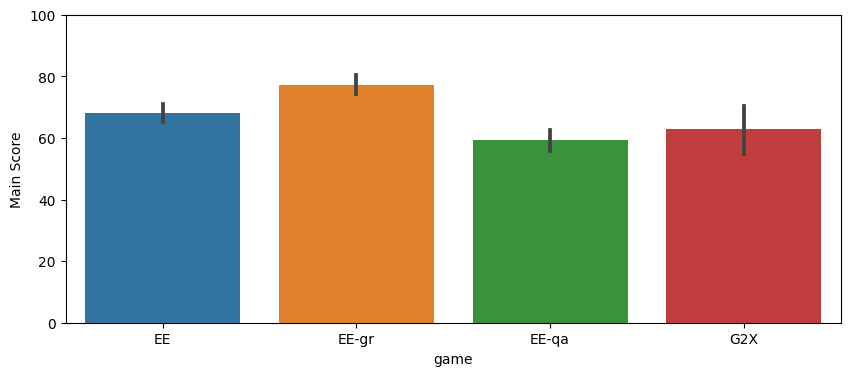

In [96]:
# change the figure size according to your needs
fig, ax = plt.subplots(figsize=(10, 4))

# choose what goes in each axis and legend according to your needs
# you can also e.g. swap y and hue, to get games in the legend and models in the axis
g = sns.barplot(metric_df,
                x='game',
                y='value',
                # hue='model', 
                ax=ax)

# customize plot details according to your needs
# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 100)
plt.ylabel(METRIC)

plt.show()

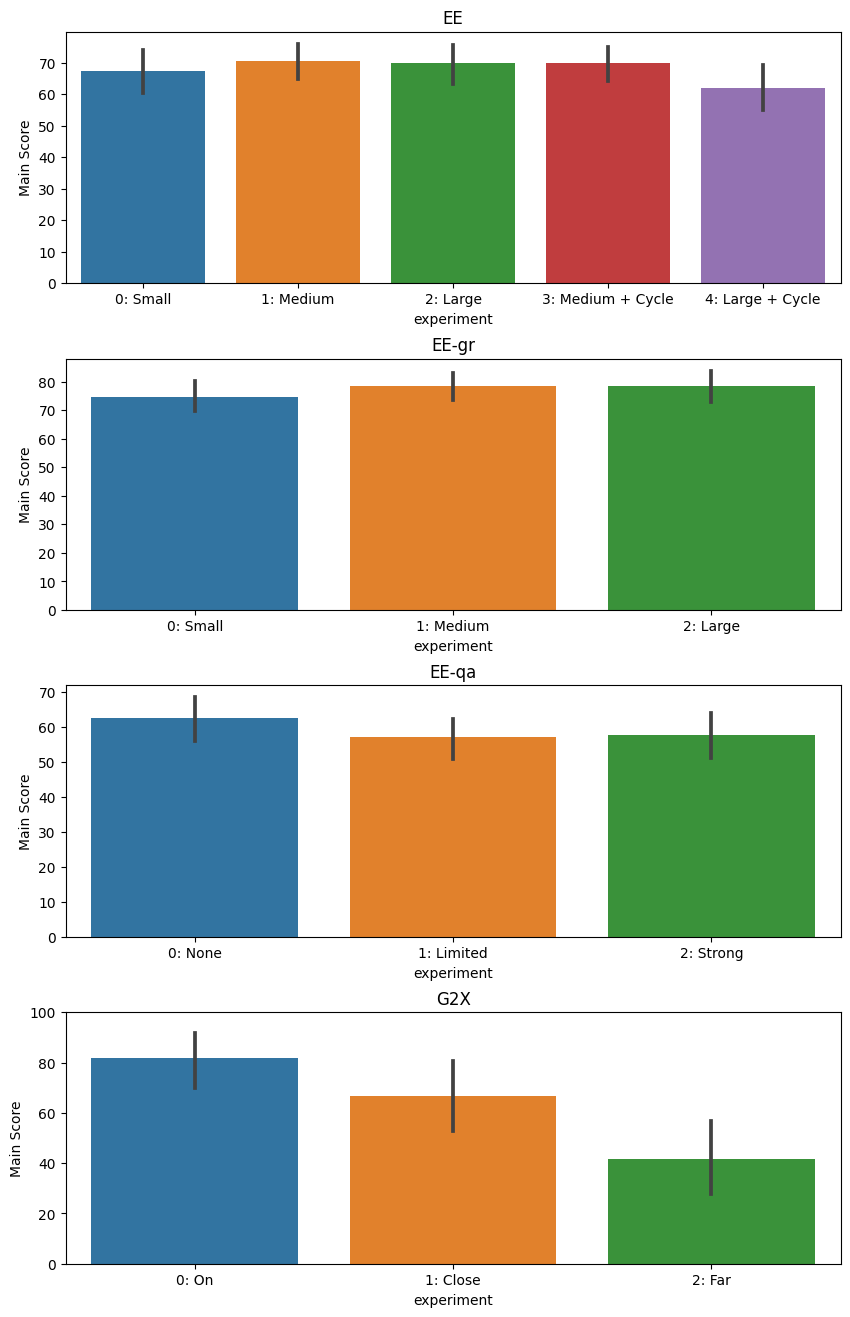

In [97]:
ee_exp_df = metric_df[metric_df.game == "EE"].sort_values('experiment')
ee_gr_exp_df = metric_df[metric_df.game == "EE-gr"].sort_values('experiment')
ee_qa_exp_df = metric_df[metric_df.game == "EE-qa"].sort_values('experiment')
g2x_exp_df = metric_df[metric_df.game == "G2X"].sort_values('experiment')

# change the figure size according to your needs
fig, ax = plt.subplots(4, 1, figsize=(10, 16))

# choose what goes in each axis and legend according to your needs
# you can also e.g. swap y and hue, to get games in the legend and models in the axis
g = sns.barplot(ee_exp_df,
                x='experiment',
                y='value',
                # hue='model', 
                ax=ax[0])

g = sns.barplot(ee_gr_exp_df,
                x='experiment',
                y='value',
                # hue='model', 
                ax=ax[1])

g = sns.barplot(ee_qa_exp_df,
                x='experiment',
                y='value',
                # hue='model', 
                ax=ax[2])

g = sns.barplot(g2x_exp_df,
                x='experiment',
                y='value',
                # hue='model', 
                ax=ax[3])


ax[0].set_title("EE")
ax[1].set_title("EE-gr")
ax[2].set_title("EE-qa")
ax[3].set_title("G2X")

# increase space between subplots slightly
plt.subplots_adjust(hspace=0.3)
# customize plot details according to your needs
# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 100)
for axis in ax:
    axis.set_ylabel(METRIC)

plt.show()

fig.savefig('../figures/experiments.pdf')

## Benchmark plots

Reproducing Figure 10 in the paper. As more models or games are added, sizes must be adjusted accordingly:

In [14]:
# read the clem scores
RESULTS_PATH = Path('../results/results.csv')
clem_df = pd.read_csv(RESULTS_PATH, index_col=0)

Horizontal bar plot with player, aborted, lost:

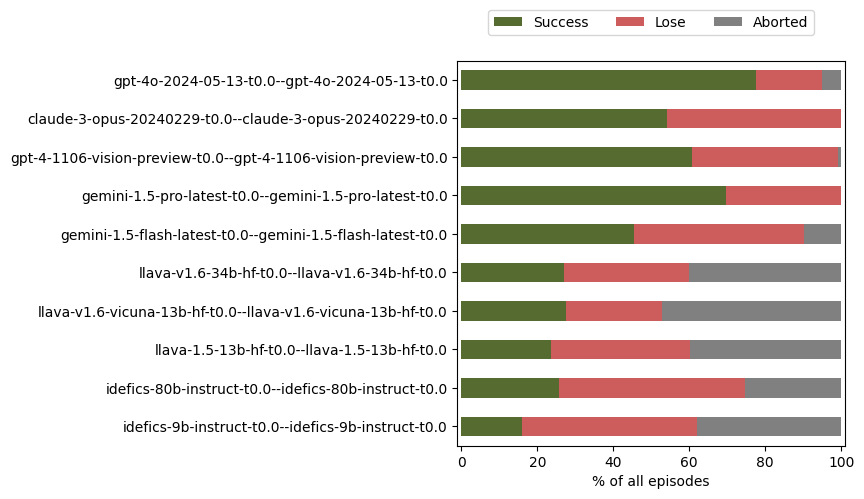

In [15]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]

df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')
plt.show()

Bar plot with the sorted clemscores (they were not sorted in the paper):

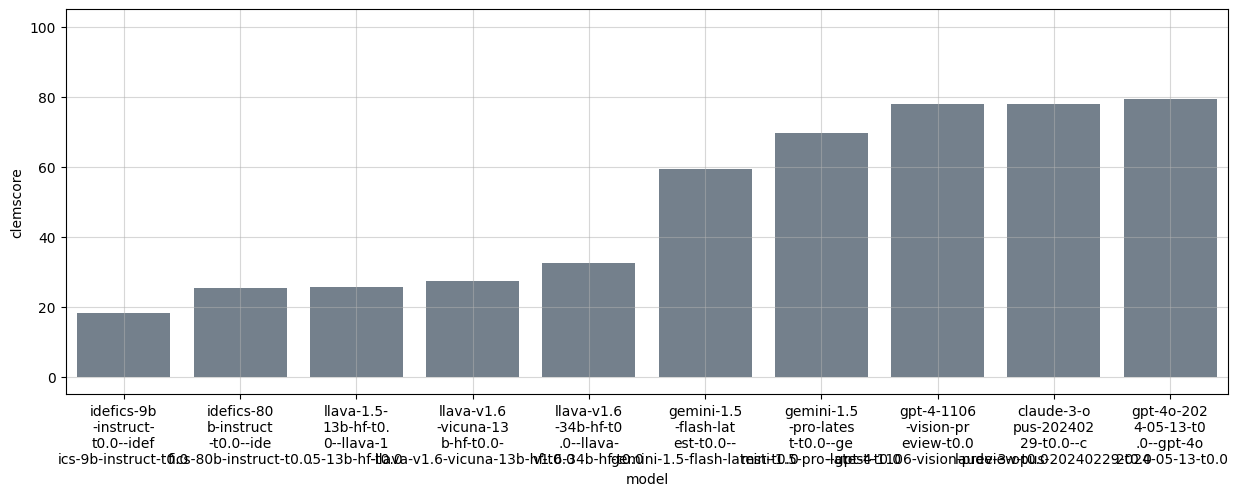

In [16]:
clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model')
# below is a hack to make the current names fit the plot
# ideally a dictionary with short names should be used as in the original implementation for the paper
# warning, if models have matching names up the limit, results will be wrongly merged!
clem_aux['model'] = clem_aux['model'].apply(lambda x: f'{x[:10]}\n{x[10:20]}\n{x[20:30]}\n{x[30:]}')

fig = plt.figure(figsize=(15, 5))
sns.barplot(clem_aux, x='model', y='-, clemscore', color='slategray')
plt.ylim(-5, 105)
plt.ylabel('clemscore')
plt.grid(alpha=0.5)
plt.show()

Polygons. This can get complicated if more games are added. In particular, COLUMN_ORDER must be adjusted. For more models, the number of subplots and figsize must be adjusted.

KeyError: 'mm_mapworld'

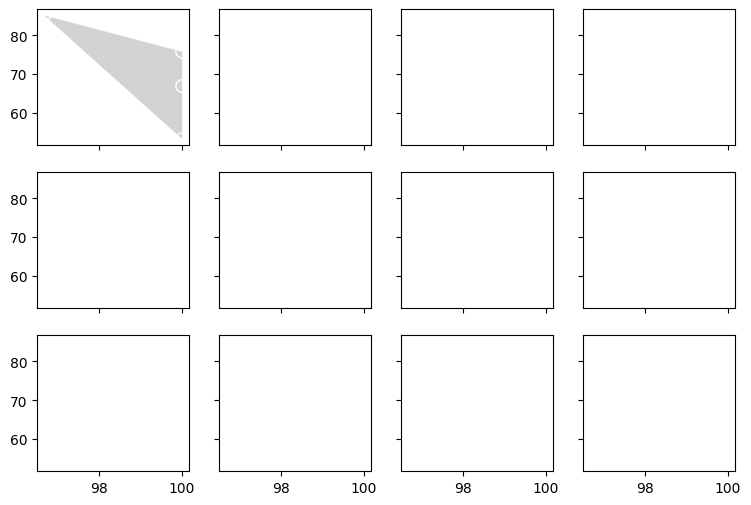

In [18]:
def ccw_sort(p):
    """Put the nodes in clockwise order."""
    # from https://stackoverflow.com/a/44143444 by user ImportanceOfBeingEarnest
    p = np.array(p)
    mean = np.mean(p, axis=0)
    d = p - mean
    s = np.arctan2(d[:, 0], d[:, 1])
    return p[np.argsort(s), :]


fig, ax_list = plt.subplots(3, 4, figsize=(9, 6), sharey=True, sharex=True)
axs = ax_list.flatten()

for n, (model, model_df) in enumerate(raw_df.groupby('model')):
    rows = model_df.metric.isin(utils.MAIN_METRICS)
    df_aux = model_df[rows]
    df_aux = (df_aux.pivot(index=['game', 'experiment', 'episode'],
                            columns='metric',
                            values='value')
                    .reset_index())
    df_aux = df_aux.drop(['episode'], axis=1)

    # create the x and y coordinates for each game
    dots = []
    for game, game_df in df_aux.groupby('game'):
        if not "mm_mapworld" in game:
            continue
        overall_means = (game_df.mean(numeric_only=True)
                                .fillna(0))
        # replace missing score by 0 when all aborted
        played = overall_means[clemmetrics.METRIC_PLAYED] * 100
        score = overall_means[clemmetrics.BENCH_SCORE]
        dots.append((game, played, score))
    labels, played, scores = zip(*dots)
    # put them in a good order for the polygon
    edges = ccw_sort(list(zip(played, scores)))

    # create the polygon and draw it
    polygon = Polygon(edges, facecolor='lightgray')
    axs[n].add_patch(polygon)

    legend = True if n == 10 else False
    g = sns.scatterplot(x=played,
                        y=scores,
                        hue=labels,
                        style=labels,
                        hue_order=utils.COLUMN_ORDER[1:],
                        style_order=utils.COLUMN_ORDER[1:],
                        s=80,
                        ax=axs[n],
                        legend=legend)
    axs[n].set_xlim(-5, 105)
    axs[n].set_ylim(-5, 105)
    axs[n].set_ylabel('avr. quality')
    axs[n].set_xlabel('% played')
    axs[n].set_title(model, fontsize=8)

fig.legend(loc='lower right', bbox_to_anchor=(0.98, 0.08))
axs[10].legend().set_visible(False)
fig.delaxes(axs[11])
plt.tight_layout()
plt.show()